In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
# paths
RESULTS_DIR = "./Results/"
DYADIC_COND = "Dyadic"
SINGLE_COND = "Single"
SINGLEC_COND = "SingleC"
EXPLORE_COND = "Exploration"

DYADIC_PAIR_MAP = { # Leader : Follower
    '1021' : '1022',
    '1023' : '1013',
    '1005' : '1055',
    '1074' : '1069',
    '1008' : '1058',
    '1054' : '1004',
    '1011' : '1017',
    '1018' : '1057'
}

# Read CSVs

In [3]:
# read raw files 
interpolation_csv_dict = {}

for condition in [DYADIC_COND, SINGLE_COND, SINGLEC_COND, EXPLORE_COND]:
    
    # add main key if not present
    if not condition in interpolation_csv_dict:
        interpolation_csv_dict[condition] = {}
    
    # read list of files 
    path_cond = "." if condition == EXPLORE_COND else condition
    file_list = glob.glob(RESULTS_DIR + path_cond + "/*interpolation_df.csv")
    
    # load each file and add to dict 
    for file_path in file_list:
        
        # extract subject id 
        subject_id = int(file_path.split("/")[-1].split("_")[0])
        
        # read file 
        df = pd.read_csv(file_path)
        
        # add column for subject id and condition 
        df["subject_id"] = subject_id
        df["condition"] = condition
        
        # add to dict 
        interpolation_csv_dict[condition][subject_id] = df


# Combine read CSVs into DataFrames for each condition 
Such that samples (and timediffs) are summed up per ColliderName for each individual PathNumber (or only ColliderName in case of the exploration). 

In [4]:
# create df for single pathfinding condition with summed up samples/ timediffs grouped by pathnumber and collidername 
single_cond_df = pd.DataFrame(columns=["PathNumber","ColliderName","Samples","timeDiff","subject_id"])

for subj_id in interpolation_csv_dict[SINGLE_COND].keys():
    curr_df = interpolation_csv_dict[SINGLE_COND][subj_id].groupby(["PathNumber","ColliderName"]).sum().drop(columns=["HMD_x","HMD_y","HMD_z","subject_id","Index"]).reset_index()
    curr_df["subject_id"] = subj_id
    single_cond_df = single_cond_df.append(curr_df)
    
single_cond_df = single_cond_df.reset_index(drop=True)


# create df for singlec pathfinding condition with summed up samples/ timediffs grouped by pathnumber and collidername 
singlec_cond_df = pd.DataFrame(columns=["PathNumber","ColliderName","Samples","timeDiff","subject_id"])

for subj_id in interpolation_csv_dict[SINGLEC_COND].keys():
    curr_df = interpolation_csv_dict[SINGLEC_COND][subj_id].groupby(["PathNumber","ColliderName"]).sum().drop(columns=["HMD_x","HMD_y","HMD_z","subject_id","Index"]).reset_index()
    curr_df["subject_id"] = subj_id
    singlec_cond_df = singlec_cond_df.append(curr_df)
    
singlec_cond_df = singlec_cond_df.reset_index(drop=True)


# create df for dyadic pathfinding condition with summed up samples/ timediffs grouped by pathnumber and collidername 
dyadic_cond_df = pd.DataFrame(columns=["PathNumber","ColliderName","Samples","timeDiff","subject_id"])

for subj_id in interpolation_csv_dict[DYADIC_COND].keys():
    curr_df = interpolation_csv_dict[DYADIC_COND][subj_id].groupby(["PathNumber","ColliderName"]).sum().drop(columns=["HMD_x","HMD_y","HMD_z","subject_id","Index"]).reset_index()
    curr_df["subject_id"] = subj_id
    dyadic_cond_df = dyadic_cond_df.append(curr_df)
    
dyadic_cond_df = dyadic_cond_df.reset_index(drop=True)


# create df for exploration condition with summed up samples/ timediffs grouped by collidername 
exploration_cond_df = pd.DataFrame(columns=["ColliderName","Samples","timeDiff","subject_id"])

for subj_id in interpolation_csv_dict[EXPLORE_COND].keys():
    curr_df = interpolation_csv_dict[EXPLORE_COND][subj_id].groupby(["ColliderName"]).sum().drop(columns=["HMD_x","HMD_y","HMD_z","subject_id","Index"]).reset_index()
    curr_df["subject_id"] = subj_id
    exploration_cond_df = exploration_cond_df.append(curr_df)
    
exploration_cond_df = exploration_cond_df.reset_index(drop=True)


print("Single Cond. Columns: " + str(single_cond_df.columns))
print("SingleC Cond. Columns: " + str(singlec_cond_df.columns))
print("Dyadic Cond. Columns: " + str(dyadic_cond_df.columns))
print("Exploration Cond. Columns: " + str(exploration_cond_df.columns))

Single Cond. Columns: Index(['PathNumber', 'ColliderName', 'Samples', 'timeDiff', 'subject_id'], dtype='object')
SingleC Cond. Columns: Index(['PathNumber', 'ColliderName', 'Samples', 'timeDiff', 'subject_id'], dtype='object')
Dyadic Cond. Columns: Index(['PathNumber', 'ColliderName', 'Samples', 'timeDiff', 'subject_id'], dtype='object')
Exploration Cond. Columns: Index(['ColliderName', 'Samples', 'timeDiff', 'subject_id'], dtype='object')


# Path dependent
### Average Samples (of all participants) on most viewed houses per path and condition
Most viewed houses are calculated per path as those, where mean over all subjects is highest. 

In [5]:
# Settings

n_top_houses = 20
path_number = 2

In [6]:
### Calculate for each condition combined samples and top houses 

## Investigate single condition paths 

# group samples per collider and per pathnumber together over multiple subjects
single_combined_df = single_cond_df.copy(deep=True)
single_combined_df["Samples"] = pd.to_numeric(single_combined_df["Samples"]) # otherwise column will be lost 
single_combined_df = single_combined_df.groupby(["PathNumber","ColliderName"]).mean()
single_combined_df = single_combined_df.sort_values(["PathNumber","Samples"],ascending=False)

# find top n houses per path over all subjects
single_exclude_colliders = ["NoHouse", "NoHit", "Phone", "Hand"]
single_top_houses_df = single_combined_df.copy(deep=True).loc[path_number].reset_index()
single_top_houses_df = single_top_houses_df.drop(index = single_top_houses_df[single_top_houses_df["ColliderName"].isin(single_exclude_colliders)].index)
single_top_houses_df = single_top_houses_df.reset_index(drop=True)


## Investigate singlec condition paths 

# group samples per collider and per pathnumber together over multiple subjects
singlec_combined_df = singlec_cond_df.copy(deep=True)
singlec_combined_df["Samples"] = pd.to_numeric(singlec_combined_df["Samples"]) # otherwise column will be lost 
singlec_combined_df = singlec_combined_df.groupby(["PathNumber","ColliderName"]).mean()
singlec_combined_df = singlec_combined_df.sort_values(["PathNumber","Samples"],ascending=False)

# find top n houses per path over all subjects
singlec_exclude_colliders = ["NoHouse", "NoHit", "Phone", "Hand"]
singlec_top_houses_df = singlec_combined_df.copy(deep=True).loc[path_number].reset_index()
singlec_top_houses_df = singlec_top_houses_df.drop(index = singlec_top_houses_df[singlec_top_houses_df["ColliderName"].isin(singlec_exclude_colliders)].index)
singlec_top_houses_df = singlec_top_houses_df.reset_index(drop=True)


## Investigate dyadic condition paths 

# group samples per collider and per pathnumber together over multiple subjects
dyadic_combined_df = dyadic_cond_df.copy(deep=True)
dyadic_combined_df["Samples"] = pd.to_numeric(dyadic_combined_df["Samples"]) # otherwise column will be lost 
dyadic_combined_df = dyadic_combined_df.groupby(["PathNumber","ColliderName"]).mean()
dyadic_combined_df = dyadic_combined_df.sort_values(["PathNumber","Samples"],ascending=False)

# find top n houses per path over all subjects
dyadic_exclude_colliders = ["NoHouse", "NoHit", "Phone", "Hand","Avatar"]
dyadic_top_houses_df = dyadic_combined_df.copy(deep=True).loc[path_number].reset_index()
dyadic_top_houses_df = dyadic_top_houses_df.drop(index = dyadic_top_houses_df[dyadic_top_houses_df["ColliderName"].isin(dyadic_exclude_colliders)].index)
dyadic_top_houses_df = dyadic_top_houses_df.reset_index(drop=True)


## Investigate exploration 

# group samples per collider and per pathnumber together over multiple subjects
exploration_combined_df = exploration_cond_df.copy(deep=True)
exploration_combined_df["Samples"] = pd.to_numeric(exploration_combined_df["Samples"]) # otherwise column will be lost 
exploration_combined_df = exploration_combined_df.groupby(["ColliderName"]).mean()
exploration_combined_df = exploration_combined_df.sort_values(["Samples"],ascending=False)

# find top n houses per path over all subjects
exploration_exclude_colliders = ["NoHouse", "NoHit", "Phone", "Hand"]
exploration_top_houses_df = exploration_combined_df.copy(deep=True).reset_index()
exploration_top_houses_df = exploration_top_houses_df.drop(index = exploration_top_houses_df[exploration_top_houses_df["ColliderName"].isin(exploration_exclude_colliders)].index)
exploration_top_houses_df = exploration_top_houses_df.reset_index(drop=True)



### Path dependent: Individual most viewed houses per condition

In [7]:
## Single condition

# cut top n houses 
single_top_houses_cut_df = single_top_houses_df.iloc[0:n_top_houses]

# filter data with individual subjects according to pathumber and top houses 
single_plotting_df = single_cond_df[(single_cond_df["PathNumber"] == path_number) & (single_cond_df["ColliderName"].isin(single_top_houses_cut_df["ColliderName"]))].sort_values(by="Samples",ascending=False)

# find order of top houses 
single_order_df = single_plotting_df.copy(deep=True)
single_order_df["Samples"] = pd.to_numeric(single_order_df["Samples"]) # otherwise column will be lost 
single_order_df = single_order_df.groupby(["ColliderName"]).mean().reset_index()
single_order_df = single_order_df.sort_values(by=["Samples"],ascending=False).reset_index(drop=True)


## Singlec condition 

# cut top n houses 
singlec_top_houses_cut_df = singlec_top_houses_df.iloc[0:n_top_houses]

# filter data with individual subjects according to pathumber and top houses 
singlec_plotting_df = singlec_cond_df[(singlec_cond_df["PathNumber"] == path_number) & (singlec_cond_df["ColliderName"].isin(singlec_top_houses_cut_df["ColliderName"]))].sort_values(by="Samples",ascending=False)

# find order of top houses 
singlec_order_df = singlec_plotting_df.copy(deep=True)
singlec_order_df["Samples"] = pd.to_numeric(singlec_order_df["Samples"]) # otherwise column will be lost 
singlec_order_df = singlec_order_df.groupby(["ColliderName"]).mean().reset_index()
singlec_order_df = singlec_order_df.sort_values(by=["Samples"],ascending=False).reset_index(drop=True)


## Dyadic condition

# cut top n houses
dyadic_top_houses_cut_df = dyadic_top_houses_df.iloc[0:n_top_houses]

# filter data with individual subjects according to pathumber and top houses 
dyadic_plotting_df = dyadic_cond_df[(dyadic_cond_df["PathNumber"] == path_number) & (dyadic_cond_df["ColliderName"].isin(dyadic_top_houses_cut_df["ColliderName"]))].sort_values(by="Samples",ascending=False)

# find order of top houses 
dyadic_order_df = dyadic_plotting_df.copy(deep=True)
dyadic_order_df["Samples"] = pd.to_numeric(dyadic_order_df["Samples"]) # otherwise column will be lost 
dyadic_order_df = dyadic_order_df.groupby(["ColliderName"]).mean().reset_index()
dyadic_order_df = dyadic_order_df.sort_values(by=["Samples"],ascending=False).reset_index(drop=True)


## Exploration condition

# cut top n houses 
exploration_top_houses_cut_df = exploration_top_houses_df.iloc[0:n_top_houses]

# filter data with individual subjects according to pathumber and top houses 
exploration_plotting_df = exploration_cond_df[exploration_cond_df["ColliderName"].isin(exploration_top_houses_cut_df["ColliderName"])].sort_values(by="Samples",ascending=False)

# find order of top houses 
exploration_order_df = exploration_plotting_df.copy(deep=True)
exploration_order_df["Samples"] = pd.to_numeric(exploration_order_df["Samples"]) # otherwise column will be lost 
exploration_order_df = exploration_order_df.groupby(["ColliderName"]).mean().reset_index()
exploration_order_df = exploration_order_df.sort_values(by=["Samples"],ascending=False).reset_index(drop=True)


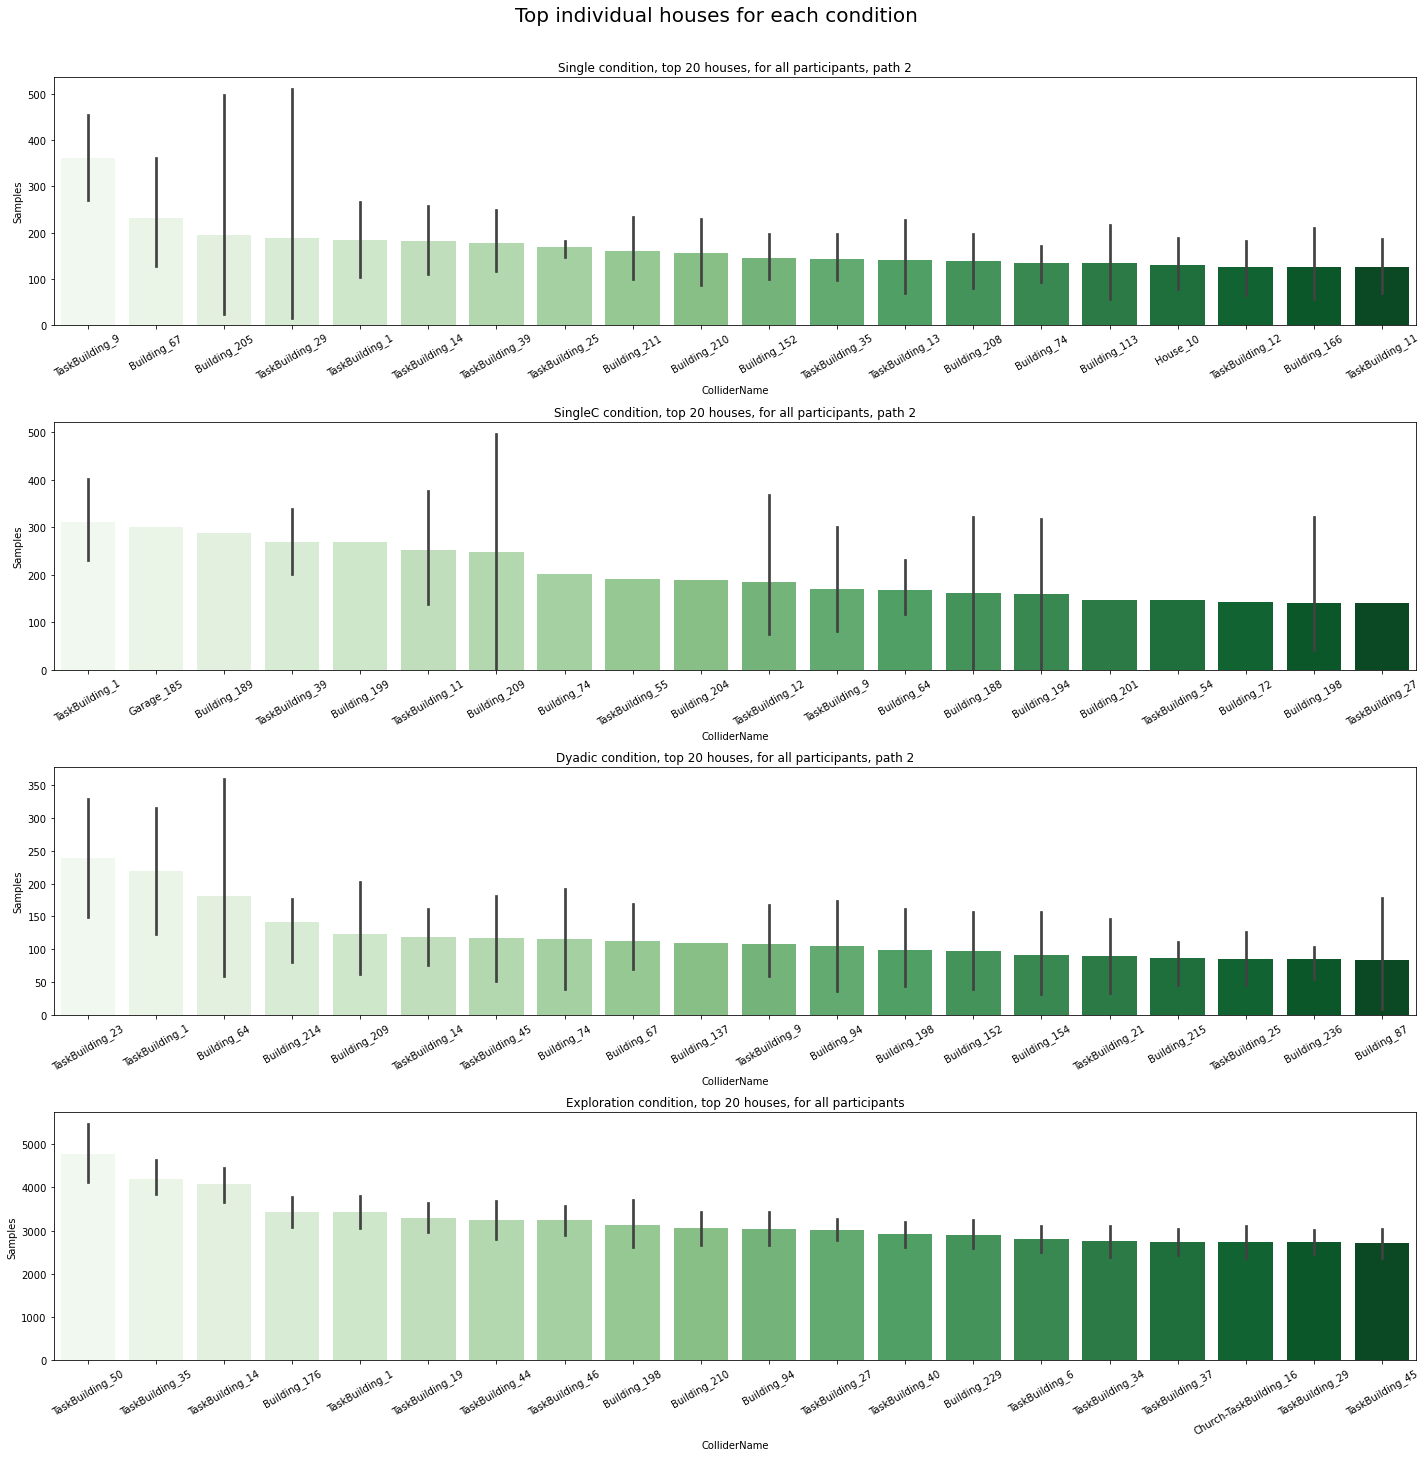

In [8]:
# plotting

fig, ax = plt.subplots(4,1,figsize=(20,20), squeeze = False)

# single
g = sns.barplot(data=single_plotting_df,x="ColliderName",y="Samples",order=single_order_df["ColliderName"],ax=ax[0,0],palette="Greens")
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[0,0].title.set_text("Single condition, top " + str(n_top_houses) + " houses, for all participants, path " + str(path_number))

# singlec 
g = sns.barplot(data=singlec_plotting_df,x="ColliderName",y="Samples",order=singlec_order_df["ColliderName"],ax=ax[1,0],palette="Greens")
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[1,0].title.set_text("SingleC condition, top " + str(n_top_houses) + " houses, for all participants, path " + str(path_number))

# dyadic
g = sns.barplot(data=dyadic_plotting_df,x="ColliderName",y="Samples",order=dyadic_order_df["ColliderName"],ax=ax[2,0],palette="Greens")
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[2,0].title.set_text("Dyadic condition, top " + str(n_top_houses) + " houses, for all participants, path " + str(path_number))

# exploration
g = sns.barplot(data=exploration_plotting_df,x="ColliderName",y="Samples",order=exploration_order_df["ColliderName"],ax=ax[3,0],palette="Greens")
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[3,0].title.set_text("Exploration condition, top " + str(n_top_houses) + " houses, for all participants")

fig.suptitle("Top individual houses for each condition", y = 1.01, fontsize = 20)
fig.tight_layout()
plt.show()

### Path dependent: Most viewed houses across all conditions


In [9]:
include_exploration = False

# extract and combine most viewed houses across all conditions
single_top_n = single_top_houses_df.iloc[0:n_top_houses]["ColliderName"]
singlec_top_n = singlec_top_houses_df.iloc[0:n_top_houses]["ColliderName"]
dyadic_top_n = dyadic_top_houses_df.iloc[0:n_top_houses]["ColliderName"]
exploration_top_n = exploration_top_houses_df.iloc[0:n_top_houses]["ColliderName"]
if include_exploration:
    combined_top_houses = list(set(list(single_top_n) + list(singlec_top_n) + list(dyadic_top_n) + list(exploration_top_n)))
else:
    combined_top_houses = list(set(list(single_top_n) + list(singlec_top_n) + list(dyadic_top_n)))


# Single: filter data with individual subjects according to pathumber and top houses 
single_plotting_df = single_cond_df[(single_cond_df["PathNumber"] == path_number) & (single_cond_df["ColliderName"].isin(combined_top_houses))].sort_values(by="Samples",ascending=False)

# SingleC: filter data with individual subjects according to pathumber and top houses 
singlec_plotting_df = singlec_cond_df[(singlec_cond_df["PathNumber"] == path_number) & (singlec_cond_df["ColliderName"].isin(combined_top_houses))].sort_values(by="Samples",ascending=False)

# Dyadic: filter data with individual subjects according to pathumber and top houses 
dyadic_plotting_df = dyadic_cond_df[(dyadic_cond_df["PathNumber"] == path_number) & (dyadic_cond_df["ColliderName"].isin(combined_top_houses))].sort_values(by="Samples",ascending=False)

# Exploration: filter data with individual subjects according to pathumber and top houses 
exploration_plotting_df = exploration_cond_df[exploration_cond_df["ColliderName"].isin(combined_top_houses)].sort_values(by="Samples",ascending=False)


# find order of top houses for all conditions based on single condition
all_order_df = single_plotting_df.copy(deep=True)
all_order_df["Samples"] = pd.to_numeric(all_order_df["Samples"]) # otherwise column will be lost 
all_order_df = all_order_df.groupby(["ColliderName"]).mean().reset_index()
all_order_df = all_order_df.sort_values(by=["Samples"],ascending=False).reset_index(drop=True)


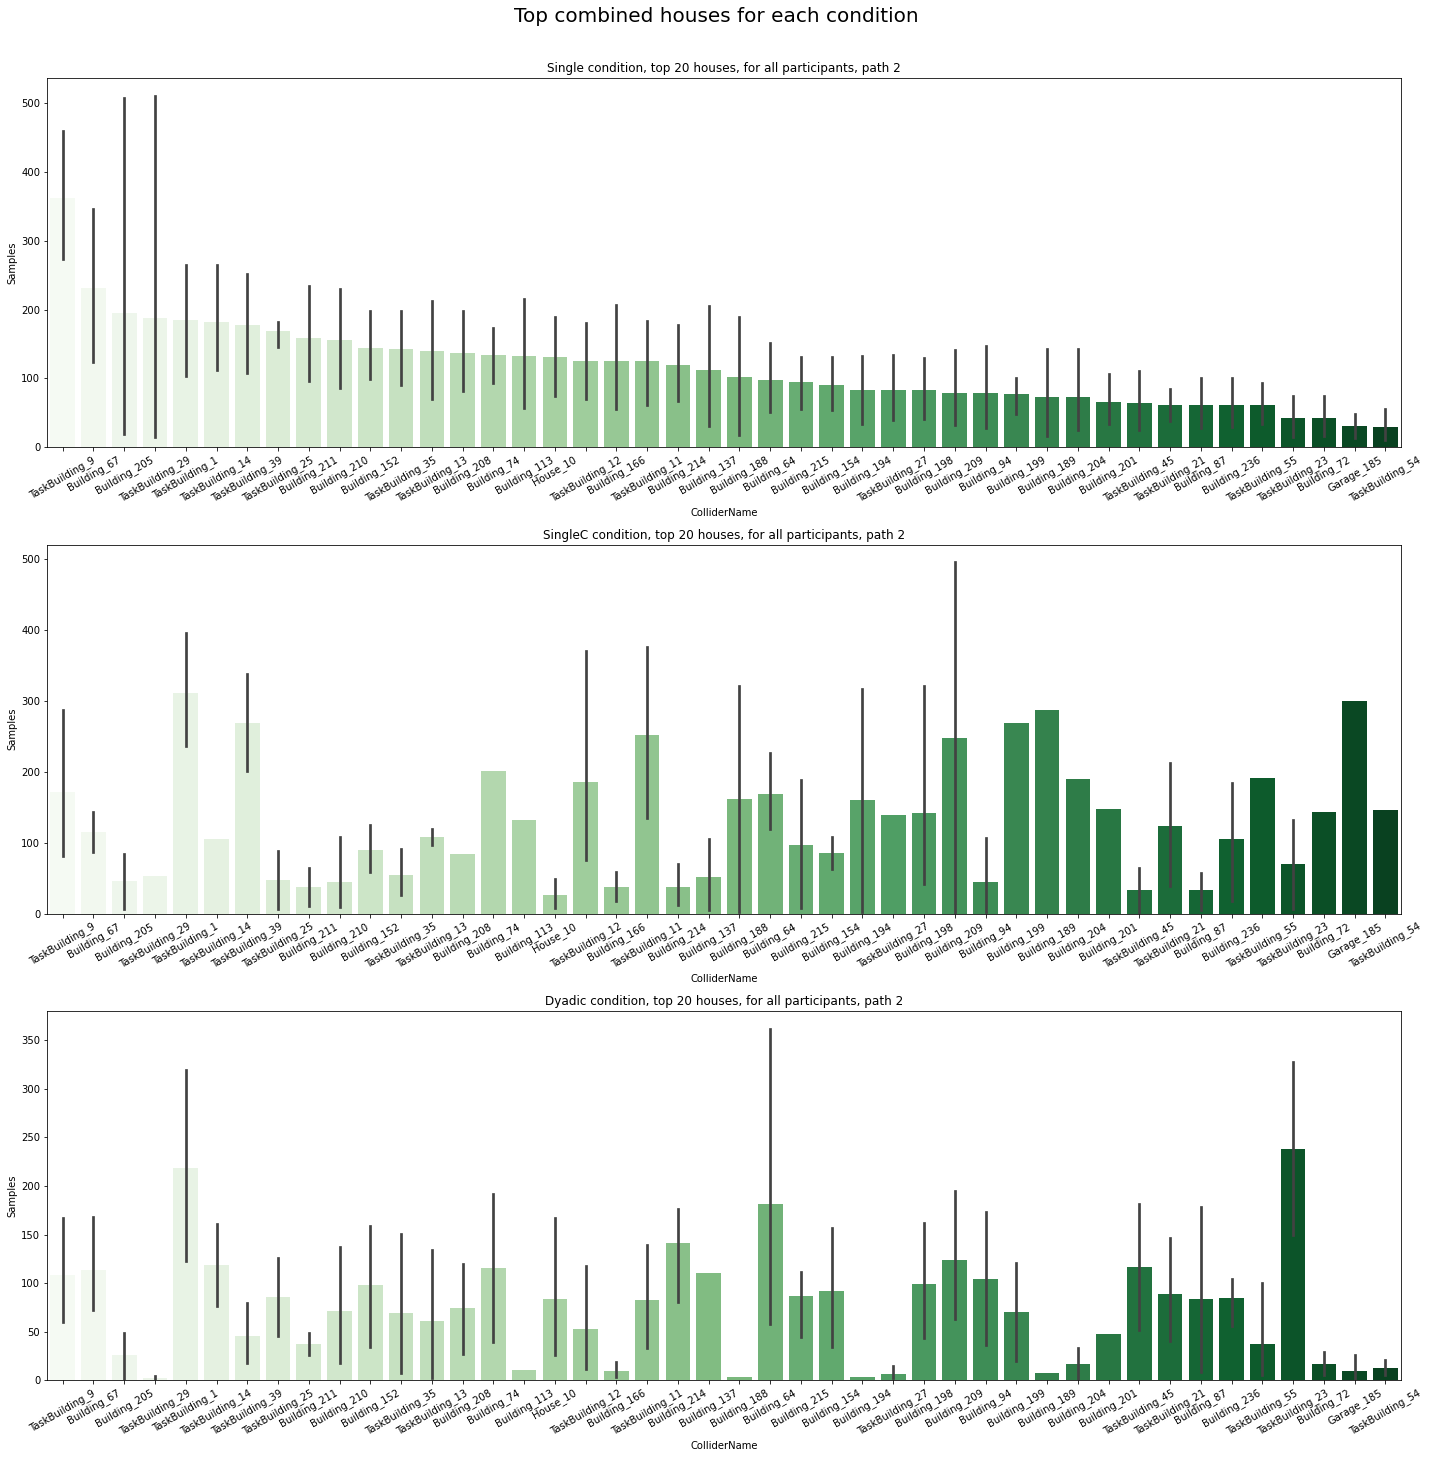

In [10]:
# plotting barplot 

if include_exploration:
    fig, ax = plt.subplots(4,1,figsize=(20,20), squeeze = False)
else:
    fig, ax = plt.subplots(3,1,figsize=(20,20), squeeze = False)

# single
g = sns.barplot(data=single_plotting_df,x="ColliderName",y="Samples",order=all_order_df["ColliderName"],ax=ax[0,0],palette="Greens")
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[0,0].title.set_text("Single condition, top " + str(n_top_houses) + " houses, for all participants, path " + str(path_number))

# singlec 
g = sns.barplot(data=singlec_plotting_df,x="ColliderName",y="Samples",order=all_order_df["ColliderName"],ax=ax[1,0],palette="Greens")
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[1,0].title.set_text("SingleC condition, top " + str(n_top_houses) + " houses, for all participants, path " + str(path_number))

# dyadic
g = sns.barplot(data=dyadic_plotting_df,x="ColliderName",y="Samples",order=all_order_df["ColliderName"],ax=ax[2,0],palette="Greens")
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[2,0].title.set_text("Dyadic condition, top " + str(n_top_houses) + " houses, for all participants, path " + str(path_number))

# exploration
if include_exploration:
    g = sns.barplot(data=exploration_plotting_df,x="ColliderName",y="Samples",order=all_order_df["ColliderName"],ax=ax[3,0],palette="Greens")
    g.set_xticklabels(g.get_xticklabels(), rotation=30)
    ax[3,0].title.set_text("Exploration condition, top " + str(n_top_houses) + " houses, for all participants")

fig.suptitle("Top combined houses for each condition", y = 1.01, fontsize = 20)
fig.tight_layout()
plt.show()

In [11]:
# lineplot with variance 

# Path independent

In [59]:
# single: group samples and timediff together for each collider of each path of each subject 
single_cond_processed = single_cond_df.copy(deep=True)
single_cond_processed["Samples"] = pd.to_numeric(single_cond_processed["Samples"]) # otherwise column will be lost 
single_cond_processed = single_cond_processed.groupby(["subject_id","PathNumber","ColliderName"]).sum().reset_index()
single_cond_processed["condition"] = "single"
single_cond_processed["leader_follower"] = np.nan

# singlec: group samples and timediff together for each collider of each path of each subject 
singlec_cond_processed = singlec_cond_df.copy(deep=True)
singlec_cond_processed["Samples"] = pd.to_numeric(singlec_cond_processed["Samples"]) # otherwise column will be lost 
singlec_cond_processed = singlec_cond_processed.groupby(["subject_id","PathNumber","ColliderName"]).sum().reset_index()
singlec_cond_processed["condition"] = "singlec"
singlec_cond_processed["leader_follower"] = np.nan

# exploration: group samples and timediff together for each collider of each path of each subject 
exploration_cond_processed = exploration_cond_df.copy(deep=True)
exploration_cond_processed["Samples"] = pd.to_numeric(exploration_cond_processed["Samples"]) # otherwise column will be lost 
exploration_cond_processed = exploration_cond_processed.groupby(["subject_id","ColliderName"]).sum().reset_index()
exploration_cond_processed["condition"] = "exploration"
exploration_cond_processed["PathNumber"] = np.nan
exploration_cond_processed["leader_follower"] = np.nan

# dyadic: group samples and timediff together for each collider of each path of each subject, map leader and follower 
dyadic_cond_processed = dyadic_cond_df.copy(deep=True)
dyadic_cond_processed["Samples"] = pd.to_numeric(dyadic_cond_processed["Samples"]) # otherwise column will be lost 
dyadic_cond_processed = dyadic_cond_processed.groupby(["subject_id","PathNumber","ColliderName"]).sum().reset_index()
dyadic_cond_processed["condition"] = "dyadic"
dyadic_cond_processed["leader_follower"] = np.nan
dyadic_cond_processed.loc[dyadic_cond_processed["subject_id"].isin(DYADIC_PAIR_MAP.keys()), "leader_follower"] = "leader"
dyadic_cond_processed.loc[~ dyadic_cond_processed["subject_id"].isin(DYADIC_PAIR_MAP.keys()), "leader_follower"] = "follower"

# combine everything 
full_agg_df = single_cond_processed.append(singlec_cond_processed).append(exploration_cond_processed).append(dyadic_cond_processed)
full_agg_df = full_agg_df.reset_index(drop=True)
print("Full aggregated dataframe columns: \n" + str(full_agg_df.columns))


Full aggregated dataframe columns: 
Index(['subject_id', 'PathNumber', 'ColliderName', 'Samples', 'timeDiff',
       'condition', 'leader_follower'],
      dtype='object')


In [96]:
# Find overall top houses

number_of_top_houses = 20
include_exploration = False

# exclude colliders that are not buildings
exclude_colliders = ["Avatar","Hand","NoHouse","NoHit","Phone"]
top_houses_df = full_agg_df.copy(deep=True)
top_houses_df = top_houses_df[(~ top_houses_df["ColliderName"].isin(exclude_colliders))] 

# sort by samples 
top_houses_df = top_houses_df.sort_values(["condition","subject_id","PathNumber","Samples"],ascending=False)

# extract top n houses, exclude  
top_house_names = []
if include_exploration: # will be weighed little however, since path is nan, i.e. only one cat per cond & subjectid 
    
    # find top n houses per group 
    raw_house_entries = top_houses_df.groupby(["condition","subject_id","PathNumber","ColliderName"]).head(number_of_top_houses)
    raw_house_entries["counter"] = 1
    
    # combine top n of each group and take from those top n 
    top_house_names = raw_house_entries.groupby("ColliderName").sum().drop(columns=["subject_id","PathNumber","Samples","timeDiff"]).sort_values("counter",ascending=False)
    top_house_names = list(top_house_names[:number_of_top_houses].reset_index()["ColliderName"])

else:
    
    # find top n houses per group 
    raw_house_entries = top_houses_df[(top_houses_df["condition"] != "exploration")].groupby(["condition","subject_id","PathNumber","ColliderName"]).head(number_of_top_houses)
    raw_house_entries["counter"] = 1
    
    # combine top n of each group and take from those top n 
    top_house_names = raw_house_entries.groupby("ColliderName").sum().drop(columns=["subject_id","PathNumber","Samples","timeDiff"]).sort_values("counter",ascending=False)
    top_house_names = list(top_house_names[:number_of_top_houses].reset_index()["ColliderName"])


print("Top Houses: \n" + str(top_house_names))


Top Houses: 
['Building_154', 'Building_176', 'Building_232', 'Building_141', 'Building_147', 'TaskBuilding_44', 'Building_97', 'Building_98', 'Building_136', 'Windmill-TaskBuilding_10_1', 'Building_94', 'Building_214', 'Building_152', 'Church-TaskBuilding_16', 'Building_229', 'Building_102', 'HighSilo-TaskBuilding_49', 'Building_92', 'TaskBuilding_26', 'Building_225']


### Within condition, different paths 

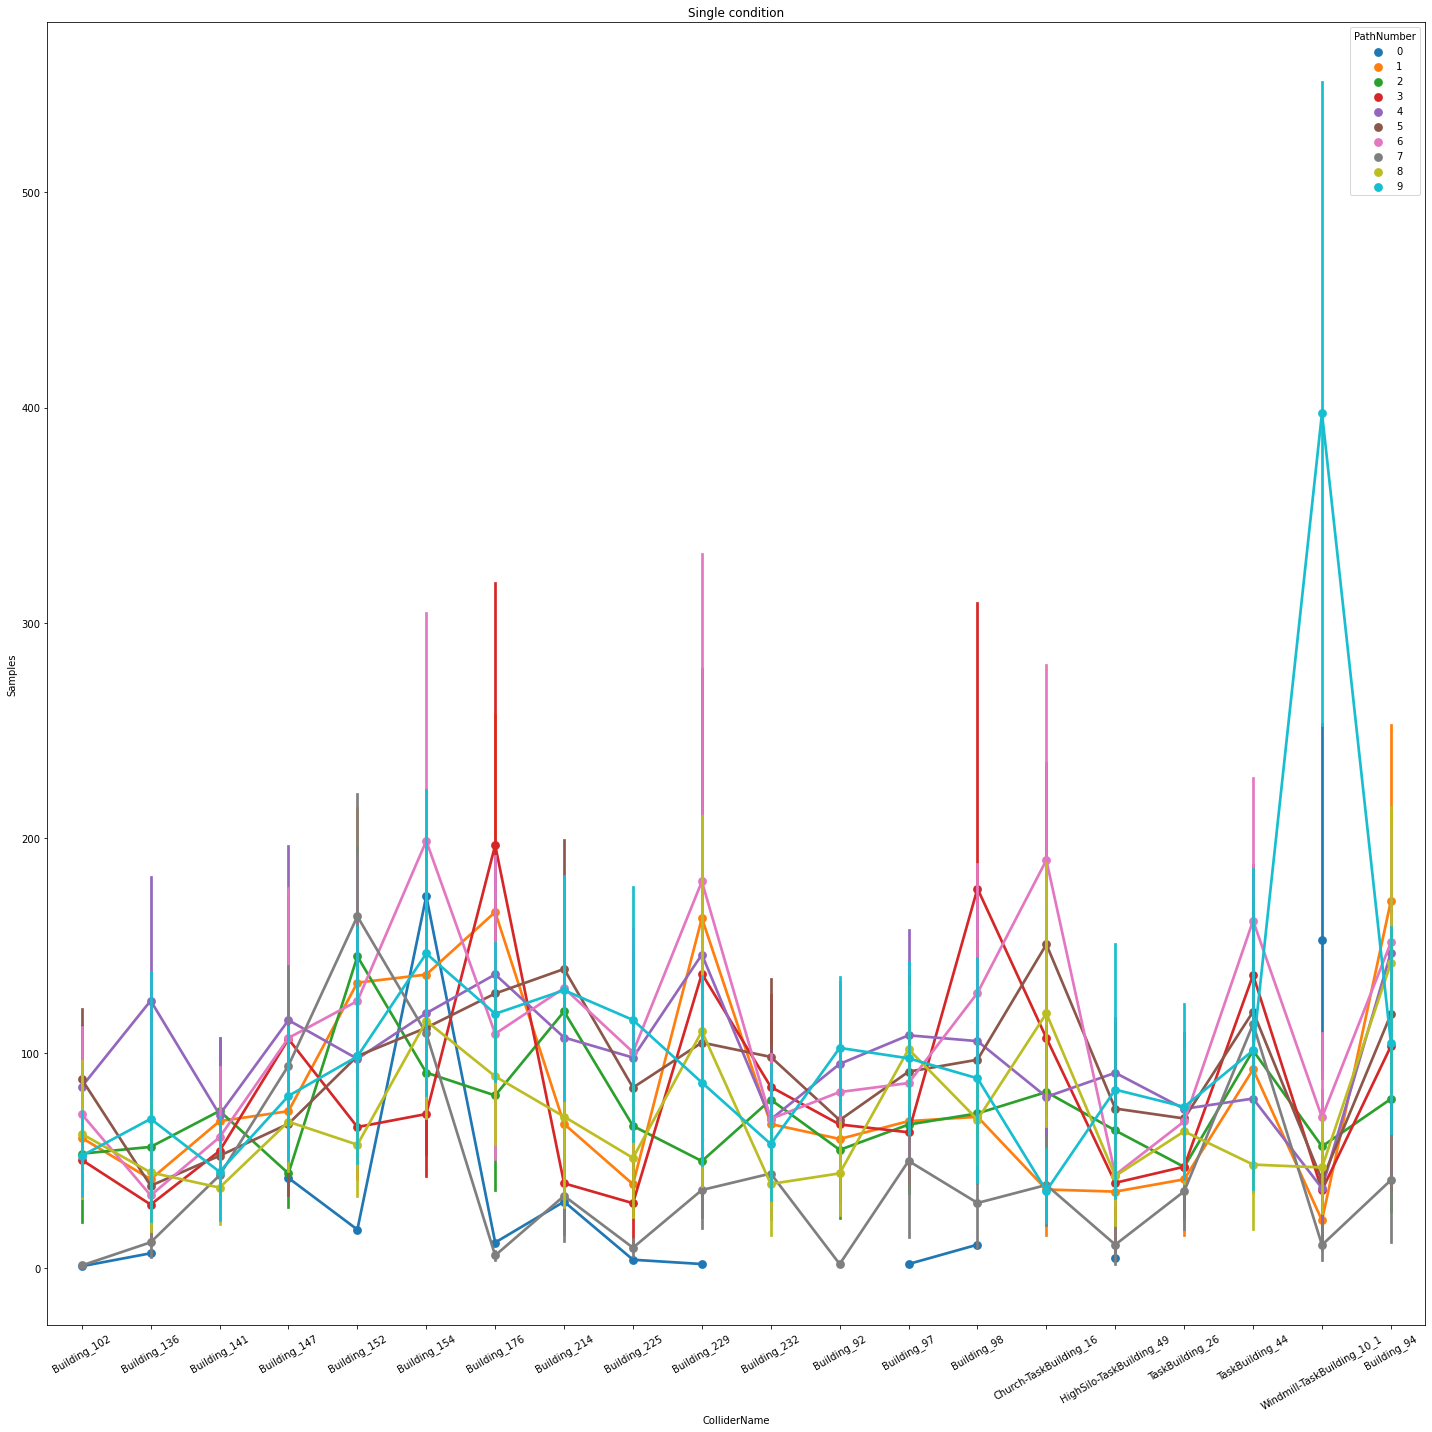

In [97]:
data_df = single_cond_df[(single_cond_df["ColliderName"].isin(top_house_names))]


fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single 
g = sns.pointplot(data=data_df, x="ColliderName", y="Samples", hue="PathNumber", ax = ax[0,0])
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[0,0].title.set_text("Single condition")


fig.tight_layout()
plt.show()

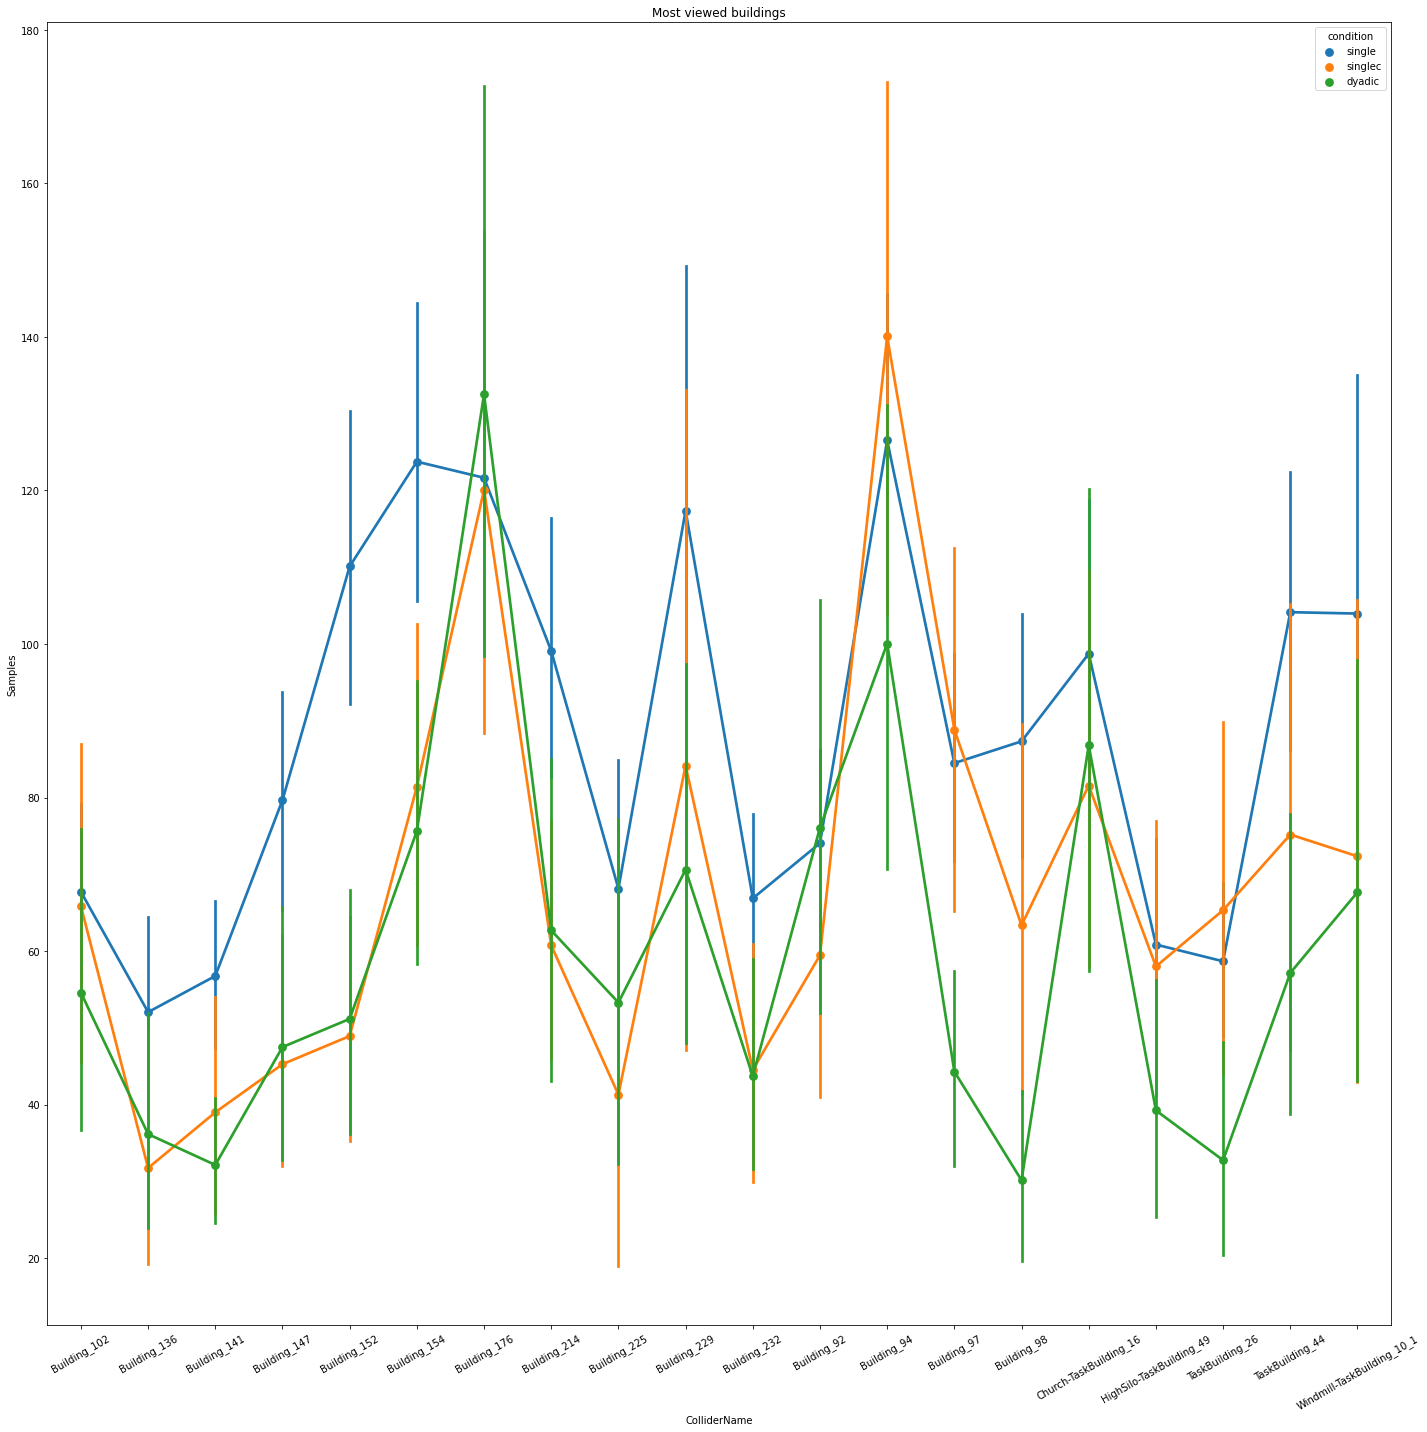

In [102]:
# Hue -> condition 

exclude_colliders = ["Avatar","Hand","NoHouse","NoHit","Phone"]
data_df = full_agg_df[(~ full_agg_df["ColliderName"].isin(exclude_colliders)) & (full_agg_df["ColliderName"].isin(top_house_names))]
if ~ include_exploration:
    data_df = data_df[data_df["condition"] != "exploration"]

fig, ax = plt.subplots(1,1,figsize=(20,20), squeeze = False)

# Single 
g = sns.pointplot(data=data_df, x="ColliderName", y="Samples", hue="condition", ax = ax[0,0])
g.set_xticklabels(g.get_xticklabels(), rotation=30)
ax[0,0].title.set_text("Most viewed buildings")


fig.tight_layout()
plt.show()

